# Introduction

In this notebook, I analyzed the data about bike rentals in Washington DC between January 2011 and December 2012. The data were provided by Hadi Fanaee-T at the University of Porto (http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The analysis was guided by https://www.dataquest.io. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


The column of interest is the 'cnt' column, since it represents the total number of bikes rented (sum of 'casual' and 'registered'). Therefore, a initial histogram helps to get a first idea of the data.

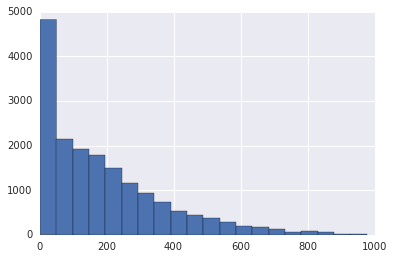

In [7]:
plt.hist(bike_rentals['cnt'],bins=20)
sns.plt.show()

As one can see, there are very few cases with high rental numbers but a lot of cases, which represent unfrequent bike rentals. In a next step, I consider the correlations with the 'cnt' column.

In [9]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

As can be seen, the total number of bike rentals is correlated with the temperature columns (humidity included), the hour of day and the year.

# Calculating Features

It can be expected that the correlation with the hour depends on the time of day. I therefore include a new column, which translates the hour into the time of day.

In [15]:
def assign_label(hour):
    if 6<=hour<12:
        return 1
    elif 12<=hour<18:
        return 2
    elif 18<=hour<=24:
        return 3
    elif 0<=hour<6:
        return 4
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

# Train/Test Split

Since I want to build a model to make further predictions, I have to divide my data into a train and test data set.

Moreover, in order to evaluate the prediction results, an error metric has to be chosen. The mean squared error makes the most sense, since the data in the 'cnt' column are numeric and continuous.

In [19]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

# Applying Linear Regression

A first simple model can be build via linear regression.

In [21]:
columns = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']

In [25]:
model = LinearRegression()
model.fit(train[columns],train['cnt'])
predictions = model.predict(test[columns])
error = np.mean((test['cnt']-predictions)**2)
print(error)

17032.8434439


As can be seen, the error of the linear regression model is extremly high. This may be caused by the huge difference in low and high rental counts.  

# Applying Decision Trees

Another model approach, which includes nonlinearities is the decision tree.

In [27]:
model2 = DecisionTreeRegressor()
model2.fit(train[columns],train['cnt'])
predictions2 = model2.predict(test[columns])
error2 = np.mean((test['cnt']-predictions2)**2)
print(error2)

3349.04976985


In [28]:
model2 = DecisionTreeRegressor(min_samples_leaf=2)
model2.fit(train[columns],train['cnt'])
predictions2 = model2.predict(test[columns])
error2 = np.mean((test['cnt']-predictions2)**2)
print(error2)

3009.48813291


In [33]:
model2 = DecisionTreeRegressor(min_samples_leaf=10)
model2.fit(train[columns],train['cnt'])
predictions2 = model2.predict(test[columns])
error2 = np.mean((test['cnt']-predictions2)**2)
print(error2)

2711.97478611


By taking the nonlinear interactions of the data into account, the decision tree regressor causes a much lower error, than linear regression. The error can be decreased even further by fixating the number of leafs.

# Applying Random Forests

Another approach is the random forest approach

In [37]:
model3 = RandomForestRegressor()
model3.fit(train[columns],train['cnt'])
predictions3 = model3.predict(test[columns])
error3 = np.mean((test['cnt']-predictions3)**2)
print(error3)

1878.23224971


In [41]:
model3 = RandomForestRegressor(min_samples_leaf=1)
model3.fit(train[columns],train['cnt'])
predictions3 = model3.predict(test[columns])
error3 = np.mean((test['cnt']-predictions3)**2)
print(error3)

1840.47975547


The error is improved once more. The random forst regressor removes some of the sources of overfitting.